Convolutional neural network mengguakan "kernel filter", di mana setiap node melakukan konvolusi seperti filter.

Kernel filter ini juga dijelaskan sebagai "receptive field" dari ukuran tertentu. sebuah output dihasilkan dari setiap posisi receptive field. kemudian posisi digeser oleh jarak yang disebut "stride", dan menghasilkan output baru, begitu seterusnya.

Convolutional neural network memiliki keunggulan, yaitu jaringan menjadi kurang tergantung pada lokasi yang tepat dari sinyal untu mendeteksi atau mengenali pola.

In [ ]:
import numpy
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import time

device='cpu'
#device='cuda'

In [ ]:
# define baseline model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(20, 10)

    def forward(self, x):
        #print("x_input.shape=", x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 4))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        #print("x.shape=", x.shape)
        x = x.view(-1, 20) #80 for pool: 2,4; ((((28-(5-1))/2-(5-1))/4)**2)*20
        #20 for pool: 4,2: ((((28-(5-1))/4-(5-1))/2)**2)*20
        x = F.relu(self.fc1(x)) #10 outputs, 1 for each class.
        return x #F.log_softmax(x)

In [ ]:
batch_size_train = 100
batch_size_test = 10
num_classes = 10

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/Downloads/MNISTfiles/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=False)

#the Normalize numbers are mean and standard deviation.
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/Downloads/MNISTfiles/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 67303364.62it/s]


Extracting /root/Downloads/MNISTfiles/MNIST/raw/train-images-idx3-ubyte.gz to /root/Downloads/MNISTfiles/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 91079469.04it/s]


Extracting /root/Downloads/MNISTfiles/MNIST/raw/train-labels-idx1-ubyte.gz to /root/Downloads/MNISTfiles/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23462628.82it/s]


Extracting /root/Downloads/MNISTfiles/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/Downloads/MNISTfiles/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14195625.01it/s]


Extracting /root/Downloads/MNISTfiles/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/Downloads/MNISTfiles/MNIST/raw



In [ ]:
examples = enumerate(train_loader)
# Plot ad hoc mnist instances

# load (downloaded if needed) the MNIST dataset
#(X_train, y_train), (X_test, y_test) = mnist.load_data()
#one batch of 100 images:
batch_idx, (X_train, y_train) = next(examples)
print("batch_idx=", batch_idx, "X_train.shape=", X_train.shape, "y_train.shape=", y_train.shape, "y_train=", y_train)
examples = enumerate(test_loader)
#one batch of 100 images:
batch_idx, (X_test, y_test) = next(examples)

batch_idx= 0 X_train.shape= torch.Size([100, 1, 28, 28]) y_train.shape= torch.Size([100]) y_train= tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7,
        1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0,
        7, 8, 3, 1])


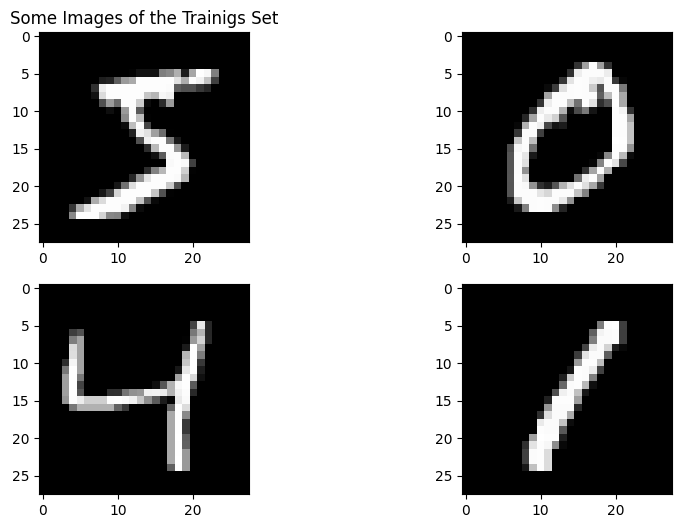

In [ ]:
# plot 4 images as gray scale
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.title("Some Images of the Trainigs Set")
plt.imshow(X_train[0,0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1,0], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2,0], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3,0], cmap=plt.get_cmap('gray'))
# show the plot


X_testunflat=X_test.clone() #keep original for imshow later
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[2] * X_train.shape[3]

In [ ]:
# build the model
print("Generate Model:")
model = ConvNet()#.to('cpu')

loss_fn = nn.CrossEntropyLoss()
#learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters())#, lr=learning_rate)

try:
    checkpoint = torch.load("mnistexample_pytorch_convnet2_weights.torch",map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("Read weights from mnistexample_pytorch_convnet2_weights.torch")
except IOError:
    print("fresh start")

Generate Model:
fresh start


In [ ]:
# Fit the model
X_train=X_train.to(device)
y_train=y_train.to(device)
starttime=time.time()
for epoch in range(1000):
    Ypred=model(X_train)
    loss=loss_fn(Ypred, y_train)
    if epoch%2==0:
        print(epoch, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
endtime=time.time()
print("Duration of optimization:", endtime-starttime)

#model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=200, verbose=2)
# Final evaluation of the model
Ypred=model(X_test)
loss=loss_fn(Ypred, y_test)
#scores = model.forward(X_test, y_test, verbose=0)
print("Loss on the test set:", loss)

0 2.3354806900024414
2 2.2612524032592773
4 2.217137336730957
6 2.174515724182129
8 2.132033586502075
10 2.089646577835083
12 2.0452258586883545
14 2.0002641677856445
16 1.9533166885375977
18 1.9035965204238892
20 1.8532094955444336
22 1.8031162023544312
24 1.7528632879257202
26 1.70338773727417
28 1.6548354625701904
30 1.6074299812316895
32 1.5617660284042358
34 1.5178632736206055
36 1.4757180213928223
38 1.4351726770401
40 1.3964039087295532
42 1.3591822385787964
44 1.3240824937820435
46 1.2908337116241455
48 1.259634256362915
50 1.2301219701766968
52 1.202316403388977
54 1.1760611534118652
56 1.1516146659851074
58 1.129160761833191
60 1.1079972982406616
62 1.088294506072998
64 1.0700035095214844
66 1.0530879497528076
68 1.0372343063354492
70 1.0223567485809326
72 1.00874662399292
74 0.9960635304450989
76 0.9841591715812683
78 0.9730338454246521
80 0.9627302289009094
82 0.9530075192451477
84 0.9441272616386414
86 0.9359073042869568
88 0.9284416437149048
90 0.9215888977050781
92 0.915

Wrote to mnistexample_pytorch_convnet2_weights.torch
sample.shape= torch.Size([1, 1, 28, 28])
prediction= tensor(6)


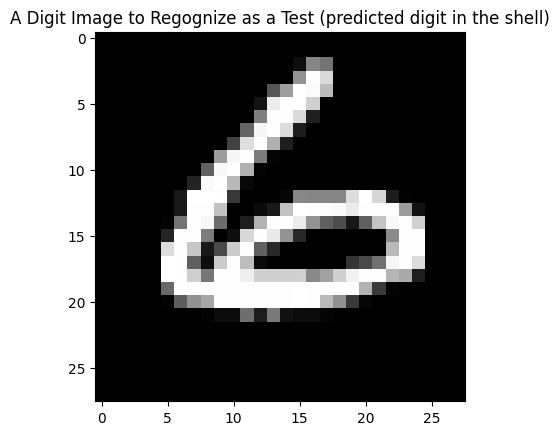

In [ ]:
torch.save({
       'model_state_dict': model.state_dict(),
       'optimizer_state_dict': optimizer.state_dict()}, "mnistexample_pytorch_convnet2_weights.torch")
print("Wrote to mnistexample_pytorch_convnet2_weights.torch")

plt.figure()
plt.imshow(X_testunflat[3,0], cmap=plt.get_cmap('gray'))
plt.title("A Digit Image to Regognize as a Test (predicted digit in the shell)")

sample=X_test[3,:]
sample=sample[None,:,:,:] #add the batch dimension for conv2d input.
print("sample.shape=", sample.shape)
prediction=torch.argmax(model(sample))
print("prediction=", prediction)

**1-D Convolutional Networks for Audio Processing**

In [ ]:
import numpy as np
sig = np.arange(0, 1.1, 0.1)
sig

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

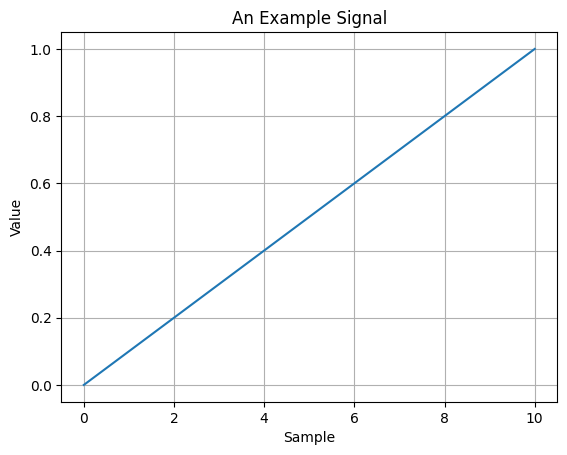

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(sig)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('An Example Signal')
plt.grid()

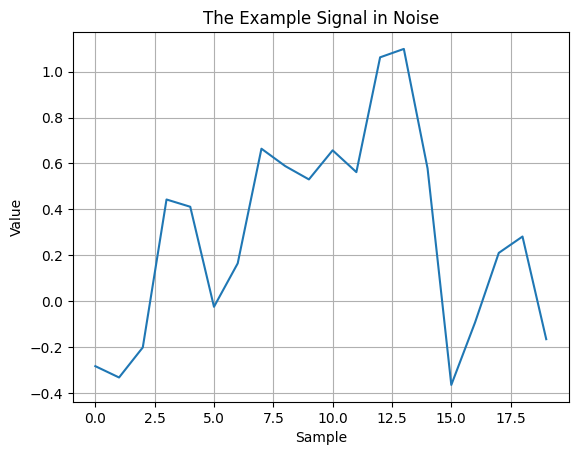

In [ ]:
signoise = np.random.rand(20)-0.5+np.hstack([np.zeros(4),sig,np.zeros(5)])
plt.figure()
plt.plot(signoise)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('The Example Signal in Noise')
plt.grid()

In [ ]:
# -*- coding: utf-8 -*-
__author__ = 'Gerald Schuller'
__copyright__ = 'G.S.'

"""
Simple program to use a convolutional neural network to obtain a signal detector like matched filter,  using pytorch.
Gerald Schuller, November 2018.
""";
# Ported to Jupyter Notebook by Renato Profeta, October 2020

In [ ]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import sys

if sys.version_info[0] < 3:
   # for Python 2
   import cPickle as pickle
else:
   # for Python 3
   import pickle

In [ ]:
# Device configuration
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def signal2pytorch(x):
    #Function to convert a signal vector s, like a mono audio signal, into a 3-d Tensor that conv1d of Pytorch expects,
    #https://pytorch.org/docs/stable/nn.html
    #conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals)
    #Argument x: a 1-d signal as numpy array
    #output: 3-d Tensor X for conv1d input.
    X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
    X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    return X

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.detector=nn.Sequential(nn.Conv1d(in_channels=1, out_channels=1, kernel_size=11, stride=1, padding=10, bias=False))
        #self.detector=nn.Conv1d(1, 1, 8, padding=8, stride=1, bias=False)

    def forward(self, x):
        out = self.detector(x)
        return out

In [ ]:
#Input signal X, a Ramp function:
x= np.hstack((np.zeros(4),np.arange(0,1.1,0.1),np.zeros(5)))
print("x=", x)
X=signal2pytorch(x)
y = np.zeros(30)
y[16]=1 #Detecting the signal at its end (for convolution padding='causal'), like a matched filter.
print("y=", y)
Y=signal2pytorch(y)

print("Input X[0,0,:]=", X[0,0,:], "X.shape=", X.shape )
print("Target Y[0,0,:]=", Y[0,0,:], "Y.shape=", Y.shape)

print("Generate Model:")
#model = generate_model()     # Compile an neural net
model = ConvNet()#.to('cpu')
print("Def. loss function:")
loss_fn = nn.MSELoss(reduction='sum')
#learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters())#, lr=learning_rate)

x= [0.  0.  0.  0.  0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  0.  0.  0.
 0.  0. ]
y= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Input X[0,0,:]= tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1000, 0.2000, 0.3000, 0.4000,
        0.5000, 0.6000, 0.7000, 0.8000, 0.9000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000]) X.shape= torch.Size([1, 1, 20])
Target Y[0,0,:]= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) Y.shape= torch.Size([1, 1, 30])
Generate Model:
Def. loss function:


In [ ]:
for epoch in range(5000):
    Ydet=model(X)
    loss=loss_fn(Ydet, Y)
    if epoch%100==0:
        print(epoch, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 1.7714059352874756
100 0.8766357898712158
200 0.6454259753227234
300 0.46990904211997986
400 0.346113920211792
500 0.2615656852722168
600 0.20380796492099762
700 0.1631392538547516
800 0.13306072354316711
900 0.10967712104320526
1000 0.09082654863595963
1100 0.07534345984458923
1200 0.06257066130638123
1300 0.05208629369735718
1400 0.04357142001390457
1500 0.0367521271109581
1600 0.03137819841504097
1700 0.027218036353588104
1800 0.0240585058927536
1900 0.021707188338041306
2000 0.019994566217064857
2100 0.01877504214644432
2200 0.017927084118127823
2300 0.017352040857076645
2400 0.016972146928310394
2500 0.01672801561653614
2600 0.016575604677200317
2700 0.016483282670378685
2800 0.016429109498858452
2900 0.016398385167121887
3000 0.016381539404392242
3100 0.01637265272438526
3200 0.016368139535188675
3300 0.016365937888622284
3400 0.01636490784585476
3500 0.01636444590985775
3600 0.01636425592005253
3700 0.016364168375730515
3800 0.016364142298698425
3900 0.01636413298547268
4000 0

In [ ]:
torch.save(model.state_dict(), 'model_detector.torch')
Ydet=model(X)
Ydet=Ydet.data.numpy()
#xnoisy=x+np.random.normal(size=x.shape)*0.1
xnoisy=x+np.random.rand(20)-0.5
Xnoisy=signal2pytorch(xnoisy)
Ydetnoisy=model(Xnoisy)
Ydetnoisy=Ydetnoisy.data.numpy()
print("Predictions= ", Ydet[0,0,:])
weights=list(model.parameters())
print("Pytorch weights=", weights[0].data.numpy())

Predictions=  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  6.5166629e-03 -7.6918185e-02 -6.1049007e-02
 -4.5723096e-02 -3.0797865e-02 -1.6138088e-02 -1.6132571e-03
  1.2904780e-02  2.7543696e-02  4.2433783e-02 -1.4282644e-02
  9.8363417e-01 -1.0308258e-02 -5.2346820e-03 -1.1858378e-03
  1.7753623e-03  3.5667068e-03  4.0847026e-03  3.2026947e-03
  7.6859904e-04  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
Pytorch weights= [[[ 7.6859904e-04  2.5109556e-03  1.2099633e-03 -6.9044007e-05
   -1.3492969e-03 -2.6540828e-03 -4.0071346e-03 -5.4325797e-03
    9.9304014e-01 -8.9951503e-01  6.5166630e-02]]]


Y= tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


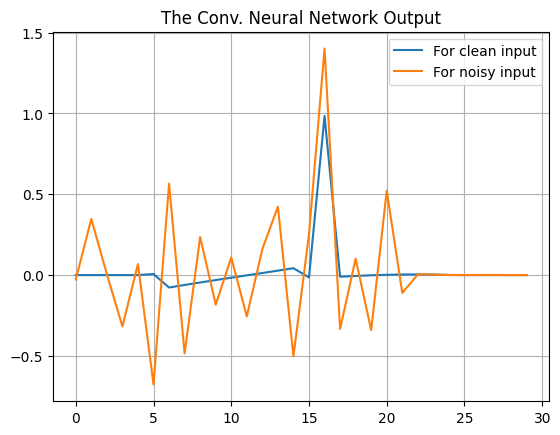

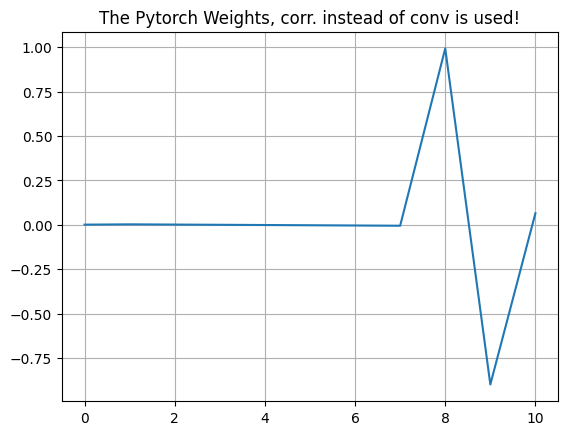

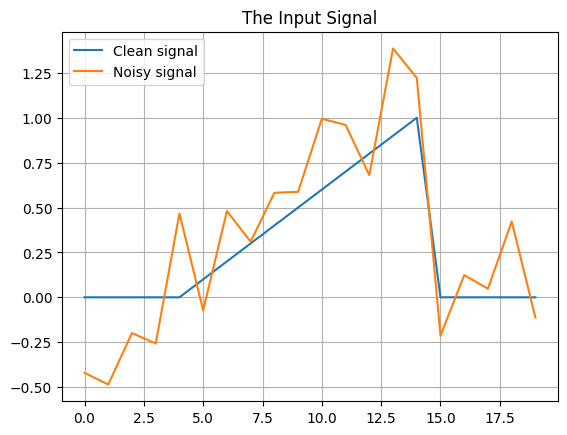

In [ ]:
print("Y=", Y)
plt.figure()
plt.plot()
plt.plot(Ydet[0,0,:])
plt.plot(Ydetnoisy[0,0,:])
plt.legend(('For clean input', 'For noisy input'))
plt.title('The Conv. Neural Network Output')
plt.grid()
plt.figure()
plt.plot(weights[0].data.numpy()[0,0,:])
plt.title('The Pytorch Weights, corr. instead of conv is used!')
plt.grid()
plt.figure()
plt.plot(x)
plt.plot(xnoisy)
plt.legend(('Clean signal', 'Noisy signal'))
plt.title('The Input Signal')
plt.grid()

**An Audio Predictor**

In [ ]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import sys
import librosa

if sys.version_info[0] < 3:
   # for Python 2
   import cPickle as pickle
else:
   # for Python 3
   import pickle

L=12 #filter length
dilation=1 #Dilation: upsampling the filter impulse response, new filter length: (L-1)*dilation+1+1


In [ ]:
def format_vector2pytorch(vector):
    #Function to convert a vector, like a mono audio signal, into a 3-d Tensor X that Keras expects
    #Tensor X with shape (batch, signal):
    #https://discuss.pytorch.org/t/confused-about-tensor-dimensions-and-batches/4761
    X = np.expand_dims(vector, axis=0)  #add batch dimension (here only 1 batch)
    X = np.expand_dims(X, axis=0)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    return X

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Define the model.
        self.layer1=nn.Sequential(nn.Conv1d(in_channels=1, out_channels=1, kernel_size=L, stride=1,
                                            dilation=dilation, padding=dilation*(L-1), bias=False))
        #https://pytorch.org/docs/stable/nn.html#conv1d
        # Generate a convolutional neural network model, 1 layer, no bias, linear activation function
        # returns: Trainable object
        #concatenate data:
        #https://discuss.pytorch.org/t/concatenate-layer-output-with-additional-input-data/20462
        #input of layer: x, output of layer: out
    def forward(self, x):
        out = self.layer1(x)
        return out

In [ ]:
#Example to find prediction coefficients to minimize the mean absolute error using Python Keras
#and 1 Convolutional layer as a predictor.

import librosa
#Input mono audio signal X:
audio, samplerate = librosa.load("./audio/ACDC - Back In Black Intro.wav", sr=None, offset=6)
#samplerate, audio = wav.read("mspeech.wav")
#samplerate, audio = wav.read("fspeech.wav")
#samplerate, audio = wav.read("WCLMSprederror.wav")
#audio=audio*1.0/2**15 #normalize
audio=audio*1.0/np.max(np.abs(audio)) #normalize

audiosh=audio[:100000] #shorten the signal for faster optimization,
#audiosh=audio[46750:47750]
plt.figure()
plt.plot(audiosh)
plt.title("The Audio Signal to Predict")
plt.grid()


X=format_vector2pytorch(audiosh[:-((L-1)*dilation+1)])      #remove last samples
Y=format_vector2pytorch(audiosh[1:]) #remove first sample, for the signal to predict, 1 sample in the future

print("Generate Model:")
print("Input X.shape=", X.shape )
print("Target Y.shape=", Y.shape)

import IPython.display as ipd
display(ipd.Audio(audiosh, rate=samplerate));

<ipython-input-25-83e916d580aa>:6: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, samplerate = librosa.load("./audio/ACDC - Back In Black Intro.wav", sr=None, offset=6)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: './audio/ACDC - Back In Black Intro.wav'

In [ ]:
print("Generate Model:")
#model = generate_model()     # Compile an neural net
model = ConvNet()#.to('cpu')
print("Def. loss function:")
loss_fn = nn.MSELoss(reduction='sum')
#learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters())#, lr=learning_rate)

In [ ]:
for epoch in range(6000):
    Ypred=model(X)
    loss=loss_fn(Ypred, Y)
    if epoch%100==0:
        print(epoch, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
torch.save({'epoch': epoch,
       'model_state_dict': model.state_dict(),
       'optimizer_state_dict': optimizer.state_dict()}, "linpredweights.torch")

In [ ]:
#Processing full length signal:
X=format_vector2pytorch(audio[:-((L-1)*dilation+1)])  #remove last samples
Y=format_vector2pytorch(audio[1:]) #remove first sample
predictions=model(X) # Make Predictions based on the obtained weights, on short audio
#mean squared predicton error:
err= sum((predictions[0,0,:]-Y[0,0,:])**2)/max(Y.shape)
print("mean squared prediction error=", err)
#mean signal power:
sigpow=sum(X[0,0,:]**2)/max(X.shape)
print("mean signal power=", sigpow)
print("Signal to Error Power Ratio:", sigpow/err)

ww = model.state_dict()   #read obtained weights
print("ww=", ww)
#weight format for Conv1d:
#[0: filter weights, 1: bias for first layer]
#weight: filters of shape: out_channels× in_channelsgroups× kW
weights=ww['layer1.0.weight'][0,0,:]


print("weights= ", weights)
#print("Predictions[0,0,:]= ", predictions[0,0,:])

In [ ]:

#print("Y=",Y)
#convert to numpy:
#https://discuss.pytorch.org/t/how-to-transform-variable-into-numpy/104/2
#plt.plot(np.array(Y[0,0,:]))
#plt.show()
plt.figure()
plt.plot(np.array(Y[0,0,:]))
plt.plot(predictions.detach().numpy()[0,0,:])
plt.legend(('Original','Predicted'))
plt.title('The Original and Predicted Signal')
plt.xlabel('Sample')
plt.grid()
plt.figure()
plt.plot(np.array(Y[0,0,:]))
plt.plot(predictions.detach().numpy()[0,0,:]-np.array(Y[0,0,:]))
plt.legend(('Original','Prediction Error'))
plt.title('The Original and Prediction Error')
plt.xlabel('Sample')
plt.grid()
plt.figure()
plt.plot(np.array(weights))
plt.title('The Weights')
plt.grid()